In [2]:
# =============================================================================
# BLOCK 1: INITIAL SETUP AND IMPORTS
# =============================================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import re
import warnings
from datetime import datetime, timedelta
from collections import Counter
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from wordcloud import WordCloud

# Sentiment analysis libraries
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from textblob import TextBlob

# Text processing
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer

# Statistical analysis
from scipy import stats
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# Download required NLTK data
nltk.download('vader_lexicon', quiet=True)
nltk.download('punkt', quiet=True)
nltk.download('stopwords', quiet=True)

# Configure display settings
warnings.filterwarnings('ignore')
plt.style.use('default')  # More compatible than seaborn-v0_8
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)

print("="*70)
print("CHANNEL POSTS COMPREHENSIVE ANALYSIS PIPELINE")
print("="*70)
print("✅ All libraries imported successfully!")

/var/folders/qn/jfqcll4s6yz52tywvfkhzr440000gn/T/ipykernel_70856/1493541271.py:5: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


CHANNEL POSTS COMPREHENSIVE ANALYSIS PIPELINE
✅ All libraries imported successfully!


In [3]:
# =============================================================================
# BLOCK 2: DATA LOADING AND INITIAL EXPLORATION
# =============================================================================

# UPDATE THIS PATH TO YOUR CSV FILE LOCATION
CSV_PATH = 'channel_posts.csv'  # Update this path

print("\n📊 PHASE 1: DATA LOADING AND EXPLORATION")
print("-"*50)

# Load the dataset
try:
    df = pd.read_csv('/Users/ritikabajpai/Desktop/channel_posts.csv', low_memory=False)
    print(f"✅ Dataset loaded successfully!")
except FileNotFoundError:
    print(f"❌ Error: File not found at {CSV_PATH}")
    print("Please update the CSV_PATH variable with the correct file path.")
    raise

print(f"📈 Dataset shape: {df.shape[0]:,} rows × {df.shape[1]} columns")
print(f"💾 Memory usage: {df.memory_usage().sum() / 1024**2:.2f} MB")

# Display column information
print(f"\n📋 Column Information:")
for i, col in enumerate(df.columns, 1):
    non_null = df[col].count()
    null_pct = (len(df) - non_null) / len(df) * 100
    dtype = str(df[col].dtype)
    print(f"  {i:2d}. {col:<20} | {dtype:<12} | {non_null:>7,} non-null ({null_pct:5.1f}% missing)")

# Display first few rows
print(f"\n👁️ Sample Data Preview:")
print(df.head())


📊 PHASE 1: DATA LOADING AND EXPLORATION
--------------------------------------------------
✅ Dataset loaded successfully!
📈 Dataset shape: 36,275 rows × 5 columns
💾 Memory usage: 1.38 MB

📋 Column Information:
   1. post_id              | int64        |  36,275 non-null (  0.0% missing)
   2. timestamp            | object       |  36,275 non-null (  0.0% missing)
   3. sender_id            | int64        |  36,275 non-null (  0.0% missing)
   4. text                 | object       |  36,275 non-null (  0.0% missing)
   5. reply_to_msg_id      | float64      |      13 non-null (100.0% missing)

👁️ Sample Data Preview:
   post_id            timestamp      sender_id                                               text  reply_to_msg_id
0    41893  2025-06-17 15:21:11 -1002232221544  #studies✍🏼  Y1S1: CS1101S Programming Methodol...              NaN
1    41892  2025-06-17 15:14:18 -1002232221544  #advice🗣️  Is it normal to be jealous of my fr...              NaN
2    41890  2025-06-17 15:05:


🧹 PHASE 2: DATA QUALITY ASSESSMENT
--------------------------------------------------
📝 Text Column Analysis ('text'):
  • Total posts: 36,275
  • Non-null texts: 36,275
  • Null texts: 0
  • Empty texts: 0
  • Duplicate texts: 16

📏 Text Length Statistics:
  • Mean length: 266.7 characters
  • Median length: 195.0 characters
  • Min length: 3
  • Max length: 4001
  • Posts < 10 chars: 3 (0.0%)


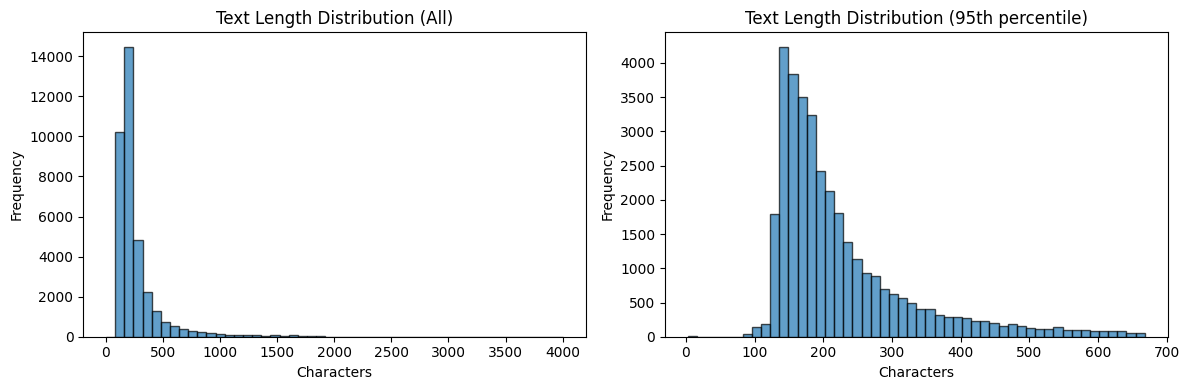

In [4]:
# =============================================================================
# BLOCK 3: DATA QUALITY ASSESSMENT
# =============================================================================

print(f"\n🧹 PHASE 2: DATA QUALITY ASSESSMENT")
print("-"*50)

# Identify text column (adjust if your column name is different)
text_col = 'text'  # Change this if your text column has a different name

if text_col not in df.columns:
    print(f"❌ Column '{text_col}' not found. Available columns:")
    print(df.columns.tolist())
    # Try to find text column automatically
    text_candidates = [col for col in df.columns if any(keyword in col.lower() 
                      for keyword in ['text', 'content', 'message', 'post', 'body'])]
    if text_candidates:
        text_col = text_candidates[0]
        print(f"🔍 Using '{text_col}' as text column")
    else:
        raise ValueError("No suitable text column found. Please specify manually.")

# Text column analysis
print(f"📝 Text Column Analysis ('{text_col}'):")
print(f"  • Total posts: {len(df):,}")
print(f"  • Non-null texts: {df[text_col].count():,}")
print(f"  • Null texts: {df[text_col].isnull().sum():,}")
print(f"  • Empty texts: {(df[text_col].astype(str) == '').sum():,}")
print(f"  • Duplicate texts: {df[text_col].duplicated().sum():,}")

# Text length analysis
df['text_length'] = df[text_col].astype(str).str.len()
print(f"\n📏 Text Length Statistics:")
print(f"  • Mean length: {df['text_length'].mean():.1f} characters")
print(f"  • Median length: {df['text_length'].median():.1f} characters")
print(f"  • Min length: {df['text_length'].min()}")
print(f"  • Max length: {df['text_length'].max()}")
print(f"  • Posts < 10 chars: {(df['text_length'] < 10).sum():,} ({(df['text_length'] < 10).mean()*100:.1f}%)")

# Display text length distribution
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.hist(df['text_length'], bins=50, alpha=0.7, edgecolor='black')
plt.title('Text Length Distribution (All)')
plt.xlabel('Characters')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)
# Remove outliers for better visualization
q95 = df['text_length'].quantile(0.95)
plt.hist(df[df['text_length'] <= q95]['text_length'], bins=50, alpha=0.7, edgecolor='black')
plt.title('Text Length Distribution (95th percentile)')
plt.xlabel('Characters')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()



⏰ PHASE 3: TEMPORAL ANALYSIS
--------------------------------------------------
📅 Found timestamp column: 'timestamp'
  • Valid timestamps: 36,275 (100.0%)
  • Date range: 2024-06-17 09:59 to 2025-06-17 15:21
  • Time span: 365 days, 5 hours
  • Posts per day (avg): 99.4


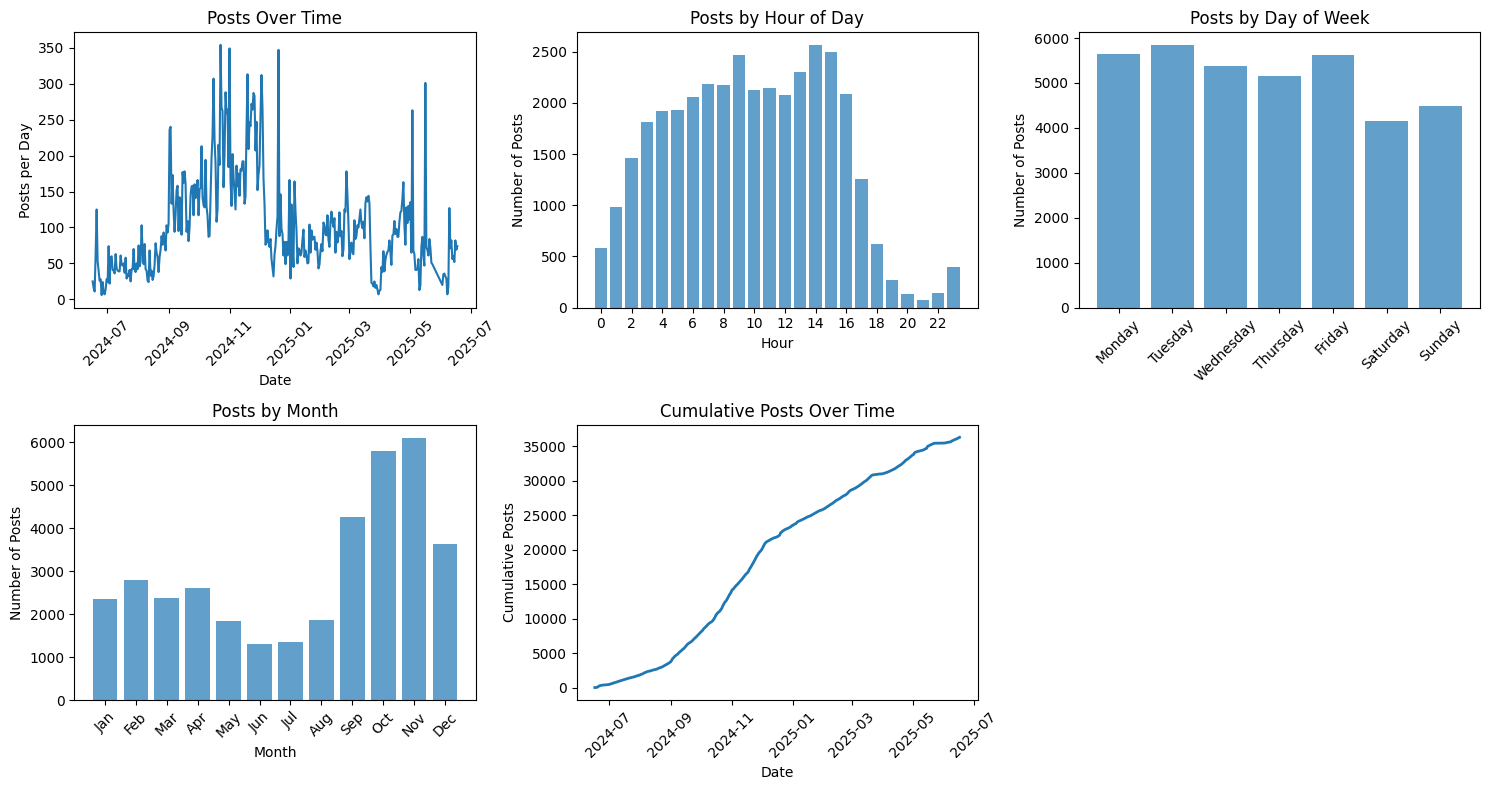

In [5]:
# =============================================================================
# BLOCK 4: TIMESTAMP ANALYSIS
# =============================================================================

print(f"\n⏰ PHASE 3: TEMPORAL ANALYSIS")
print("-"*50)

# Find timestamp column
timestamp_candidates = [col for col in df.columns if any(keyword in col.lower() 
                       for keyword in ['time', 'date', 'created', 'posted', 'timestamp'])]

if timestamp_candidates:
    timestamp_col = timestamp_candidates[0]
    print(f"📅 Found timestamp column: '{timestamp_col}'")
    
    # Parse timestamps
    try:
        df['parsed_datetime'] = pd.to_datetime(df[timestamp_col], errors='coerce')
        valid_timestamps = df['parsed_datetime'].notna().sum()
        print(f"  • Valid timestamps: {valid_timestamps:,} ({valid_timestamps/len(df)*100:.1f}%)")
        
        if valid_timestamps > 0:
            # Extract time components
            df['date'] = df['parsed_datetime'].dt.date
            df['hour'] = df['parsed_datetime'].dt.hour
            df['day_of_week'] = df['parsed_datetime'].dt.day_name()
            df['month'] = df['parsed_datetime'].dt.month
            df['year'] = df['parsed_datetime'].dt.year
            
            # Time range
            min_date = df['parsed_datetime'].min()
            max_date = df['parsed_datetime'].max()
            date_range = max_date - min_date
            
            print(f"  • Date range: {min_date.strftime('%Y-%m-%d %H:%M')} to {max_date.strftime('%Y-%m-%d %H:%M')}")
            print(f"  • Time span: {date_range.days} days, {date_range.seconds//3600} hours")
            
            if date_range.days > 0:
                print(f"  • Posts per day (avg): {len(df)/date_range.days:.1f}")
                
            # Create temporal visualizations
            plt.figure(figsize=(15, 8))
            
            # Posts over time
            plt.subplot(2, 3, 1)
            daily_posts = df.groupby(df['parsed_datetime'].dt.date).size()
            plt.plot(daily_posts.index, daily_posts.values, linewidth=1.5)
            plt.title('Posts Over Time')
            plt.xlabel('Date')
            plt.ylabel('Posts per Day')
            plt.xticks(rotation=45)
            
            # Hourly distribution
            plt.subplot(2, 3, 2)
            hourly_posts = df['hour'].value_counts().sort_index()
            plt.bar(hourly_posts.index, hourly_posts.values, alpha=0.7)
            plt.title('Posts by Hour of Day')
            plt.xlabel('Hour')
            plt.ylabel('Number of Posts')
            plt.xticks(range(0, 24, 2))
            
            # Day of week distribution
            plt.subplot(2, 3, 3)
            dow_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
            dow_posts = df['day_of_week'].value_counts().reindex(dow_order, fill_value=0)
            plt.bar(dow_posts.index, dow_posts.values, alpha=0.7)
            plt.title('Posts by Day of Week')
            plt.ylabel('Number of Posts')
            plt.xticks(rotation=45)
            
            # Monthly distribution
            plt.subplot(2, 3, 4)
            monthly_posts = df['month'].value_counts().sort_index()
            month_names = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 
                          'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
            plt.bar(monthly_posts.index, monthly_posts.values, alpha=0.7)
            plt.title('Posts by Month')
            plt.xlabel('Month')
            plt.ylabel('Number of Posts')
            plt.xticks(range(1, 13), month_names, rotation=45)
            
            # Cumulative posts
            plt.subplot(2, 3, 5)
            cumulative_posts = daily_posts.cumsum()
            plt.plot(cumulative_posts.index, cumulative_posts.values, linewidth=2)
            plt.title('Cumulative Posts Over Time')
            plt.xlabel('Date')
            plt.ylabel('Cumulative Posts')
            plt.xticks(rotation=45)
            
            plt.tight_layout()
            plt.show()
            
    except Exception as e:
        print(f"❌ Error parsing timestamps: {e}")
        timestamp_col = None
else:
    print("⚠️  No timestamp column found")
    timestamp_col = None



🔤 PHASE 4: TEXT PREPROCESSING
--------------------------------------------------
🧼 Cleaning text data...
  • Original posts: 36,275
  • Posts after cleaning: 36,275
  • Posts removed: 0 (0.0%)
  • Working with 36,275 clean posts

📝 Cleaning Examples:

Original: #studies✍🏼  Y1S1: CS1101S Programming Methodology MA1100T Basic Discrete Mathematics (T) MA2001 Line...
Cleaned:  studies✍🏼 Y1S1: CS1101S Programming Methodology MA1100T Basic Discrete Mathematics (T) MA2001 Linear...

Original: #advice🗣️  Is it normal to be jealous of my friend who got into Jp Morgan while I only got into a bo...
Cleaned:  advice🗣️ Is it normal to be jealous of my friend who got into Jp Morgan while I only got into a bout...

Original: #advice🗣️  Financial Advisors 🗣 or Fast Moving Consumer Good Resellers 📦 roles are underrated intern...
Cleaned:  advice🗣️ Financial Advisors 🗣 or Fast Moving Consumer Good Resellers 📦 roles are underrated internsh...


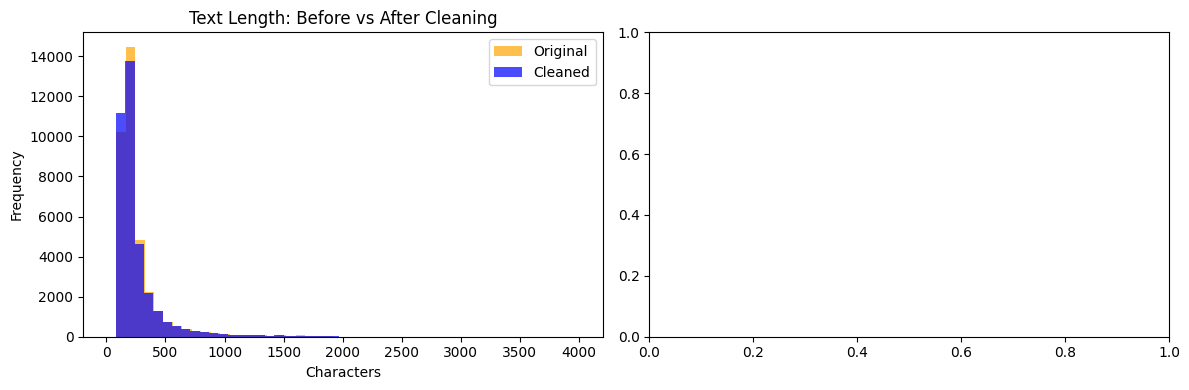

In [6]:
# =============================================================================
# BLOCK 5: TEXT PREPROCESSING
# =============================================================================

print(f"\n🔤 PHASE 4: TEXT PREPROCESSING")
print("-"*50)

def advanced_text_cleaning(text):
    """Advanced text cleaning for better analysis"""
    if pd.isna(text) or str(text).strip() == '':
        return None
    
    text = str(text)
    
    # Basic cleaning
    text = text.strip()
    
    # Remove URLs
    text = re.sub(r'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\\(\\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+', '', text)
    
    # Remove email addresses
    text = re.sub(r'\S+@\S+', '', text)
    
    # Handle hashtags (keep the word, remove #)
    text = re.sub(r'#(\w+)', r'\1', text)
    
    # Remove @mentions
    text = re.sub(r'@\w+', '', text)
    
    # Normalize excessive punctuation
    text = re.sub(r'[!]{2,}', '! ', text)
    text = re.sub(r'[?]{2,}', '? ', text)
    text = re.sub(r'[.]{3,}', '... ', text)
    
    # Remove excessive whitespace
    text = re.sub(r'\s+', ' ', text)
    text = text.strip()
    
    # Return None if text becomes too short after cleaning
    return text if len(text) >= 3 else None

# Apply text cleaning
print("🧼 Cleaning text data...")
df['cleaned_text'] = df[text_col].apply(advanced_text_cleaning)
df['cleaned_length'] = df['cleaned_text'].astype(str).str.len()

# Cleaning statistics
original_count = len(df)
cleaned_count = df['cleaned_text'].notna().sum()
print(f"  • Original posts: {original_count:,}")
print(f"  • Posts after cleaning: {cleaned_count:,}")
print(f"  • Posts removed: {original_count - cleaned_count:,} ({(original_count - cleaned_count)/original_count*100:.1f}%)")

# Filter to valid posts for analysis
df_clean = df[df['cleaned_text'].notna()].copy()
print(f"  • Working with {len(df_clean):,} clean posts")

# Show cleaning effect
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.hist(df['text_length'], bins=50, alpha=0.7, label='Original', color='orange')
plt.hist(df_clean['cleaned_length'], bins=50, alpha=0.7, label='Cleaned', color='blue')
plt.title('Text Length: Before vs After Cleaning')
plt.xlabel('Characters')
plt.ylabel('Frequency')
plt.legend()

plt.subplot(1, 2, 2)
# Show a few examples of cleaning
examples = df_clean[['text', 'cleaned_text']].head(3)
print("\n📝 Cleaning Examples:")
for idx, row in examples.iterrows():
    print(f"\nOriginal: {str(row['text'])[:100]}...")
    print(f"Cleaned:  {str(row['cleaned_text'])[:100]}...")

plt.tight_layout()
plt.show()


😊 PHASE 5: SENTIMENT ANALYSIS
--------------------------------------------------
🔍 Analyzing sentiment with VADER and TextBlob...

🎯 Testing sentiment classification thresholds:
  Threshold ±0.05: Pos 96.3% | Neu 0.5% | Neg 3.1%
  Threshold ±0.1: Pos 96.1% | Neu 1.0% | Neg 2.9%
  Threshold ±0.15: Pos 95.8% | Neu 1.6% | Neg 2.6%
  Threshold ±0.2: Pos 95.3% | Neu 2.4% | Neg 2.4%
  Threshold ±0.25: Pos 94.8% | Neu 3.1% | Neg 2.1%

✅ Sentiment analysis completed using threshold: ±0.15
  • Positive: 34,738 (95.8%)
  • Negative: 958 (2.6%)
  • Neutral: 579 (1.6%)


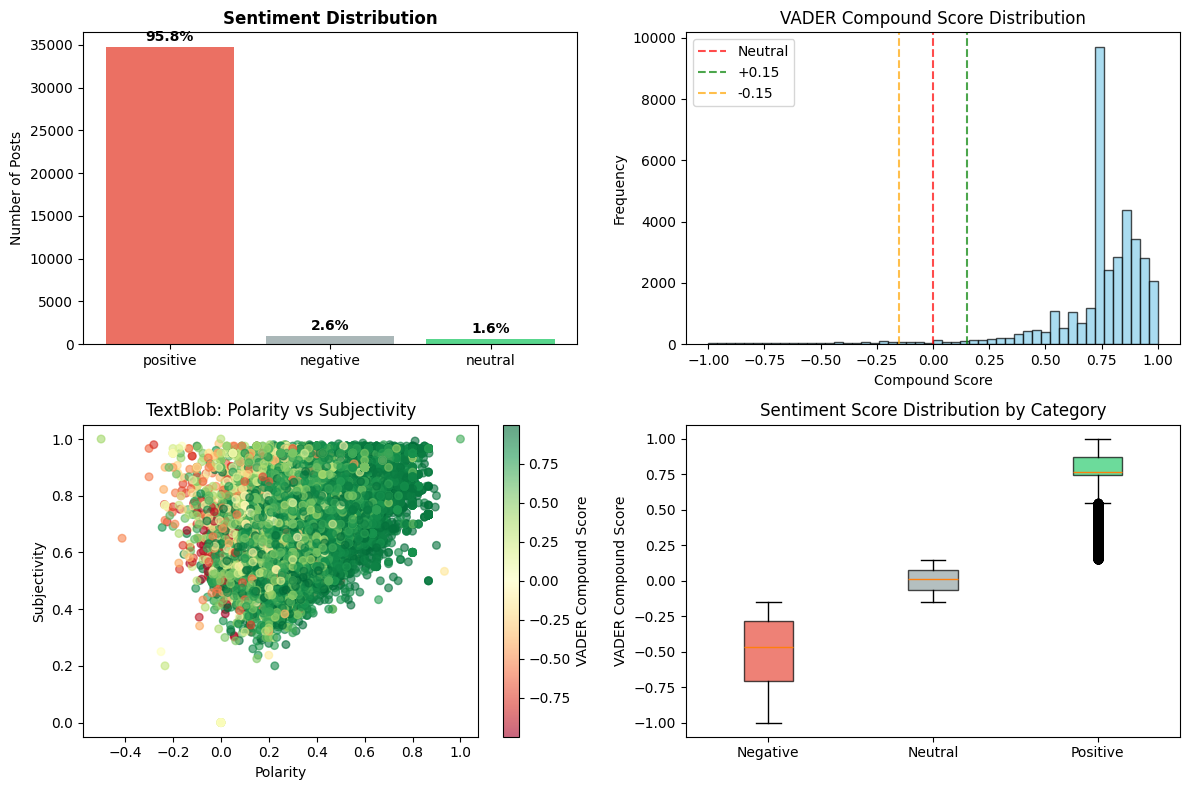

In [7]:
# =============================================================================
# BLOCK 6: SENTIMENT ANALYSIS
# =============================================================================

print(f"\n😊 PHASE 5: SENTIMENT ANALYSIS")
print("-"*50)

# Initialize sentiment analyzers
sia = SentimentIntensityAnalyzer()

def get_vader_scores(text):
    """Get VADER sentiment scores"""
    if pd.isna(text) or text == '':
        return {'compound': 0, 'pos': 0, 'neu': 0, 'neg': 0}
    return sia.polarity_scores(str(text))

def get_textblob_sentiment(text):
    """Get TextBlob sentiment"""
    if pd.isna(text) or text == '':
        return 0, 0
    try:
        blob = TextBlob(str(text))
        return blob.sentiment.polarity, blob.sentiment.subjectivity
    except:
        return 0, 0

print("🔍 Analyzing sentiment with VADER and TextBlob...")

# VADER sentiment analysis
vader_results = df_clean['cleaned_text'].apply(get_vader_scores)
df_clean['vader_compound'] = [result['compound'] for result in vader_results]
df_clean['vader_pos'] = [result['pos'] for result in vader_results]
df_clean['vader_neu'] = [result['neu'] for result in vader_results]
df_clean['vader_neg'] = [result['neg'] for result in vader_results]

# TextBlob sentiment analysis
textblob_results = df_clean['cleaned_text'].apply(get_textblob_sentiment)
df_clean['textblob_polarity'] = [result[0] for result in textblob_results]
df_clean['textblob_subjectivity'] = [result[1] for result in textblob_results]

# Sentiment classification function
def classify_sentiment(score, threshold=0.1):
    if score >= threshold:
        return 'positive'
    elif score <= -threshold:
        return 'negative'
    else:
        return 'neutral'

# Test different thresholds for optimal classification
thresholds = [0.05, 0.1, 0.15, 0.2, 0.25]
print("\n🎯 Testing sentiment classification thresholds:")

for thresh in thresholds:
    sentiment_labels = df_clean['vader_compound'].apply(lambda x: classify_sentiment(x, thresh))
    counts = sentiment_labels.value_counts()
    pos_pct = counts.get('positive', 0) / len(sentiment_labels) * 100
    neg_pct = counts.get('negative', 0) / len(sentiment_labels) * 100
    neu_pct = counts.get('neutral', 0) / len(sentiment_labels) * 100
    print(f"  Threshold ±{thresh}: Pos {pos_pct:.1f}% | Neu {neu_pct:.1f}% | Neg {neg_pct:.1f}%")

# Use optimal threshold (balanced distribution)
optimal_threshold = 0.15
df_clean['sentiment_label'] = df_clean['vader_compound'].apply(lambda x: classify_sentiment(x, optimal_threshold))

print(f"\n✅ Sentiment analysis completed using threshold: ±{optimal_threshold}")

# Display final sentiment distribution
sentiment_dist = df_clean['sentiment_label'].value_counts()
for sentiment, count in sentiment_dist.items():
    pct = count / len(df_clean) * 100
    print(f"  • {sentiment.capitalize()}: {count:,} ({pct:.1f}%)")

# Sentiment distribution visualization
plt.figure(figsize=(12, 8))

plt.subplot(2, 2, 1)
colors = ['#e74c3c', '#95a5a6', '#2ecc71']  # red, gray, green
sentiment_counts = df_clean['sentiment_label'].value_counts()
bars = plt.bar(sentiment_counts.index, sentiment_counts.values, color=colors, alpha=0.8)
plt.title('Sentiment Distribution', fontweight='bold')
plt.ylabel('Number of Posts')

# Add percentages on bars
for bar, count in zip(bars, sentiment_counts.values):
    pct = count / len(df_clean) * 100
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + len(df_clean)*0.01, 
             f'{pct:.1f}%', ha='center', va='bottom', fontweight='bold')

plt.subplot(2, 2, 2)
plt.hist(df_clean['vader_compound'], bins=50, alpha=0.7, color='skyblue', edgecolor='black')
plt.axvline(x=0, color='red', linestyle='--', alpha=0.7, label='Neutral')
plt.axvline(x=optimal_threshold, color='green', linestyle='--', alpha=0.7, label=f'+{optimal_threshold}')
plt.axvline(x=-optimal_threshold, color='orange', linestyle='--', alpha=0.7, label=f'-{optimal_threshold}')
plt.title('VADER Compound Score Distribution')
plt.xlabel('Compound Score')
plt.ylabel('Frequency')
plt.legend()

plt.subplot(2, 2, 3)
scatter = plt.scatter(df_clean['textblob_polarity'], df_clean['textblob_subjectivity'], 
                     c=df_clean['vader_compound'], cmap='RdYlGn', alpha=0.6, s=30)
plt.colorbar(scatter, label='VADER Compound Score')
plt.title('TextBlob: Polarity vs Subjectivity')
plt.xlabel('Polarity')
plt.ylabel('Subjectivity')

plt.subplot(2, 2, 4)
# Box plot of sentiment scores
sentiment_data = [df_clean[df_clean['sentiment_label'] == sentiment]['vader_compound'].values 
                  for sentiment in ['negative', 'neutral', 'positive']]
box_plot = plt.boxplot(sentiment_data, labels=['Negative', 'Neutral', 'Positive'], patch_artist=True)
colors = ['#e74c3c', '#95a5a6', '#2ecc71']
for patch, color in zip(box_plot['boxes'], colors):
    patch.set_facecolor(color)
    patch.set_alpha(0.7)
plt.title('Sentiment Score Distribution by Category')
plt.ylabel('VADER Compound Score')

plt.tight_layout()
plt.show()


📚 PHASE 6: TEXT ANALYTICS
--------------------------------------------------
🔍 Analyzing word frequencies...
💬 Most common words (after filtering):
   1. anyone: 3,861
   2. get: 3,788
   3. know: 2,785
   4. one: 2,776
   5. people: 2,642
   6. guys: 2,481
   7. even: 2,419
   8. got: 2,271
   9. time: 2,260
  10. want: 2,203
  11. good: 1,944
  12. think: 1,904
  13. really: 1,816
  14. still: 1,751
  15. need: 1,687

💎 Most meaningful words (after additional filtering):
   1. class: 1,587
   2. guy: 1,566
   3. love: 1,306
   4. internship: 1,268
   5. girl: 1,238
   6. life: 1,200
   7. friends: 1,176
   8. girls: 1,148
   9. finals: 1,137
  10. group: 1,129
  11. prof: 1,128
  12. day: 1,124
  13. better: 1,082
  14. gpa: 1,055
  15. first: 1,053

📊 Topic analysis:
  • academic: 7,247 mentions
  • social: 7,061 mentions
  • lifestyle: 3,904 mentions
  • internship_career: 3,860 mentions
  • personal: 2,795 mentions
  • campus_life: 1,831 mentions
  • technology: 1,308 mentions
  

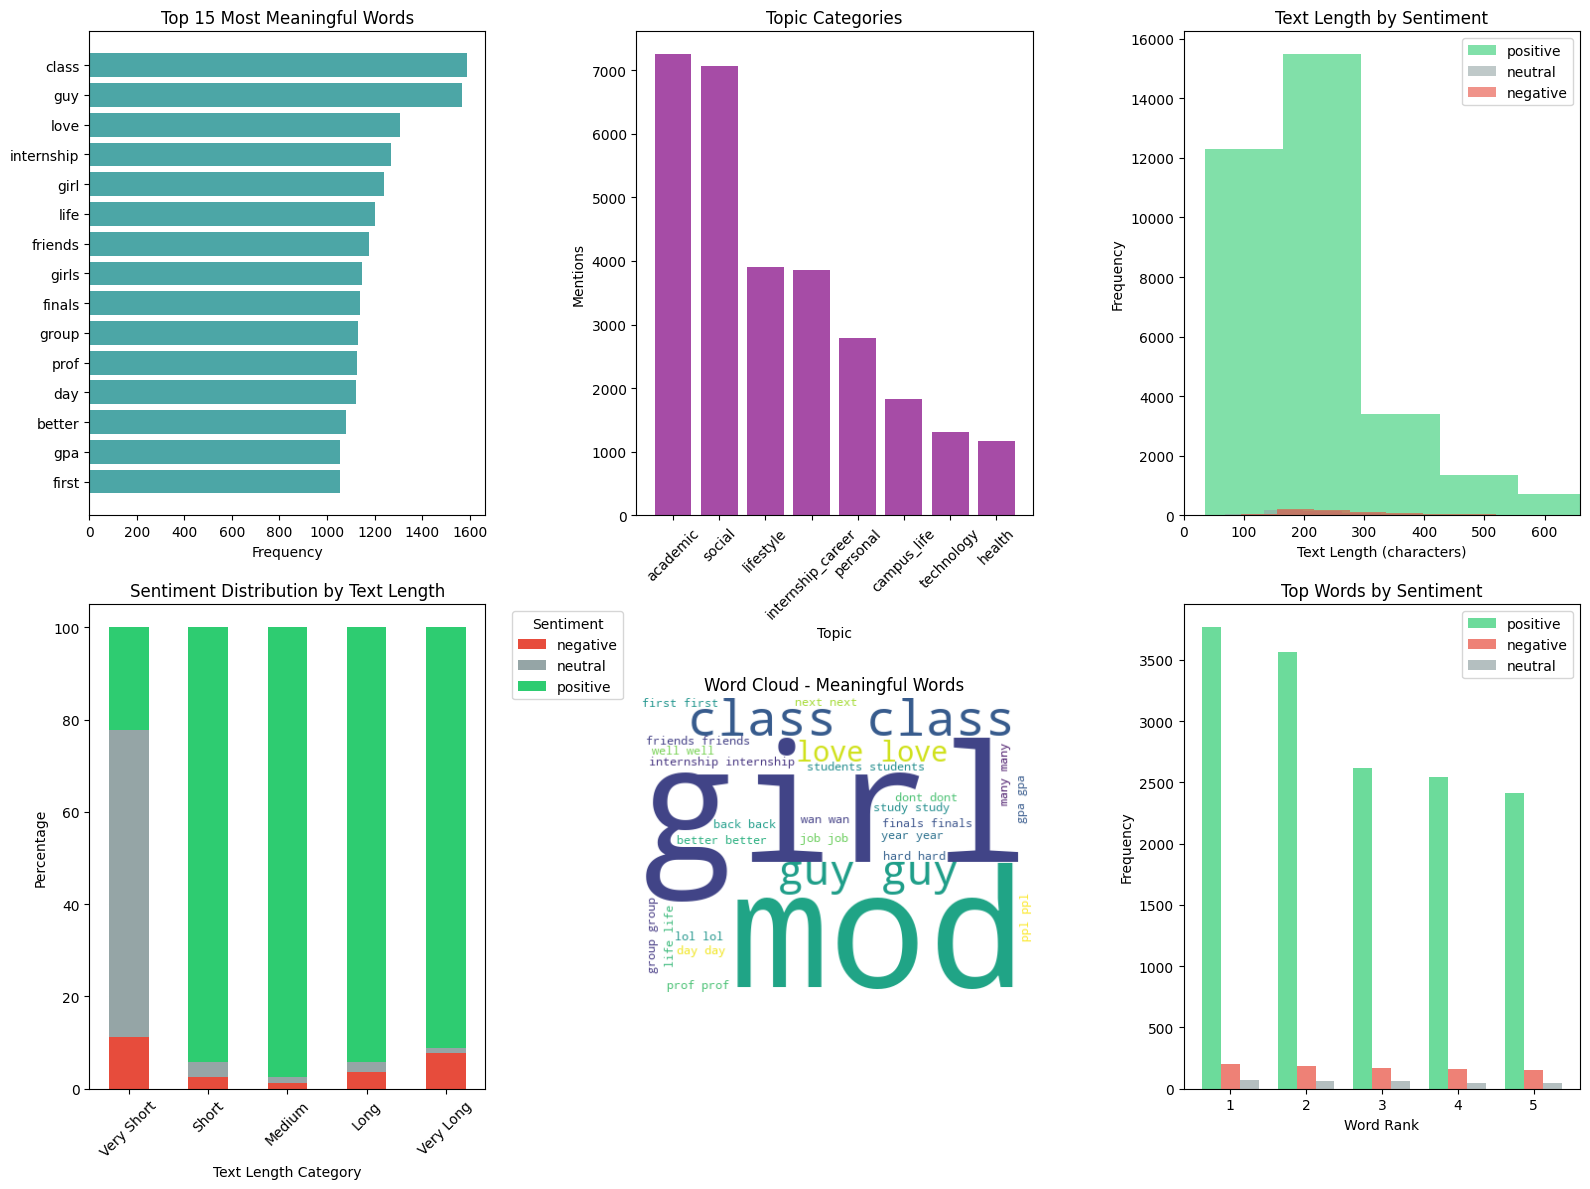


✅ Text analytics completed!
   • Found 30 meaningful words
   • Identified 8 topic categories
   • Analyzed sentiment-specific vocabulary


In [8]:
# =============================================================================
# BLOCK 7: TEXT ANALYTICS AND WORD FREQUENCY
# =============================================================================

print(f"\n📚 PHASE 6: TEXT ANALYTICS")
print("-"*50)

# Word frequency analysis
print("🔍 Analyzing word frequencies...")

# Get all words for analysis
all_text = ' '.join(df_clean['cleaned_text'].astype(str))
words = word_tokenize(all_text.lower())

# Remove stopwords and filter
stop_words = set(stopwords.words('english'))
# Add custom stopwords for channel data (including the repetitive confession-related terms)
custom_stopwords = {
    'channel', 'post', 'like', 'comment', 'share', 'please', 'thanks', 'thank', 'much',
    'smu', 'confess', 'confession', 'kind', 'form', 'fill', 'anonymous', 'submit',
    'website', 'link', 'https', 'http', 'www', 'com', 'org', 'net'
}
stop_words.update(custom_stopwords)

words_filtered = [word for word in words if word.isalpha() and word not in stop_words and len(word) > 2]

# Most common words (all words)
word_freq = Counter(words_filtered)
top_words = word_freq.most_common(20)

print(f"💬 Most common words (after filtering):")
for i, (word, count) in enumerate(top_words[:15], 1):
    print(f"  {i:2d}. {word}: {count:,}")

# Create meaningful words by filtering out very common but low-information words
# Additional filtering for more meaningful analysis
additional_filter = {
    'anyone', 'get', 'know', 'one', 'people', 'guys', 'even', 'got', 'time',
    'really', 'want', 'need', 'thing', 'things', 'way', 'good', 'bad', 'make',
    'like', 'just', 'think', 'feel', 'look', 'see', 'say', 'come', 'go', 'take',
    'give', 'use', 'work', 'find', 'help', 'ask', 'tell', 'call', 'try', 'keep',
    'still', 'yall', 'someone', 'would', 'everyone', 'also', 'meow', 
     'school',   'would', 'everyone', 'going', 'pls'
}


# Filter for meaningful words
meaningful_words_filtered = [word for word in words_filtered if word not in additional_filter]
meaningful_word_freq = Counter(meaningful_words_filtered)
top_meaningful_words = meaningful_word_freq.most_common(30)

print(f"\n💎 Most meaningful words (after additional filtering):")
for i, (word, count) in enumerate(top_meaningful_words[:15], 1):
    print(f"  {i:2d}. {word}: {count:,}")

# Topic analysis - identify potential topics from meaningful words
topic_keywords = {
    'academic': ['study', 'exam', 'grade', 'class', 'professor', 'assignment', 'test', 'homework', 
                'lecture', 'tutorial', 'presentation', 'project', 'thesis', 'research', 'module',
                'semester', 'finals', 'midterm', 'quiz', 'gpa', 'scholarship'],
    'social': ['friend', 'friends', 'relationship', 'dating', 'love', 'party', 'social', 'meet',
              'boyfriend', 'girlfriend', 'crush', 'date', 'together', 'couple', 'single',
              'marriage', 'wedding', 'breakup', 'drama'],
    'personal': ['family', 'home', 'personal', 'private', 'secret', 'worry', 'stress', 'anxiety',
                'depression', 'mental', 'emotional', 'feelings', 'sad', 'happy', 'angry',
                'scared', 'lonely', 'confidence', 'insecure'],
    'lifestyle': ['food', 'money', 'job', 'work', 'career', 'future', 'life', 'travel',
                 'shopping', 'hobby', 'interest', 'passion', 'dream', 'goal', 'ambition'],
    'health': ['health', 'mental', 'physical', 'tired', 'sleep', 'exercise', 'sick', 'doctor',
              'medicine', 'hospital', 'pain', 'weight', 'fitness', 'diet'],
    'technology': ['phone', 'computer', 'internet', 'media', 'online', 'app', 'social',
                  'instagram', 'facebook', 'twitter', 'tiktok', 'youtube', 'gaming', 'game'],
    'internship_career': ['internship', 'intern', 'job', 'career', 'interview', 'resume',
                         'application', 'company', 'salary', 'professional', 'networking'],
    'campus_life': ['hall', 'hostel', 'canteen', 'library', 'campus', 'cca', 'club', 'society',
                   'event', 'competition', 'sports', 'gym']
}

# Count mentions of each topic
topic_counts = {}
for topic, keywords in topic_keywords.items():
    count = sum(meaningful_word_freq.get(keyword, 0) for keyword in keywords)
    if count > 0:
        topic_counts[topic] = count

sorted_topics = sorted(topic_counts.items(), key=lambda x: x[1], reverse=True)

print(f"\n📊 Topic analysis:")
for topic, count in sorted_topics:
    print(f"  • {topic}: {count:,} mentions")

# Sentiment-specific word analysis
print(f"\n🎭 Sentiment-specific word analysis:")
sentiment_words = {}
for sentiment in ['positive', 'negative', 'neutral']:
    sentiment_texts = df_clean[df_clean['sentiment_label'] == sentiment]['cleaned_text']
    if len(sentiment_texts) > 0:
        sentiment_text_combined = ' '.join(sentiment_texts.astype(str))
        sentiment_words_list = word_tokenize(sentiment_text_combined.lower())
        sentiment_words_filtered = [word for word in sentiment_words_list 
                                   if word.isalpha() and word not in stop_words and len(word) > 2]
        sentiment_words[sentiment] = Counter(sentiment_words_filtered)
        
        print(f"\n  {sentiment.upper()} - Top meaningful words:")
        for word, count in sentiment_words[sentiment].most_common(10):
            print(f"    • {word}: {count:,}")

# Create visualizations
plt.figure(figsize=(16, 12))

# Meaningful word frequency bar chart
plt.subplot(2, 3, 1)
if top_meaningful_words:
    top_words_df = pd.DataFrame(top_meaningful_words[:15], columns=['word', 'count'])
    plt.barh(top_words_df['word'], top_words_df['count'], color='teal', alpha=0.7)
    plt.title('Top 15 Most Meaningful Words')
    plt.xlabel('Frequency')
    plt.gca().invert_yaxis()
else:
    plt.text(0.5, 0.5, 'No meaningful words\nafter filtering', ha='center', va='center', 
             transform=plt.gca().transAxes)
    plt.title('Word Analysis')

# Topic categories visualization
plt.subplot(2, 3, 2)
if sorted_topics:
    topics_df = pd.DataFrame(sorted_topics, columns=['topic', 'count'])
    plt.bar(topics_df['topic'], topics_df['count'], color='purple', alpha=0.7)
    plt.title('Topic Categories')
    plt.xlabel('Topic')
    plt.ylabel('Mentions')
    plt.xticks(rotation=45)
else:
    plt.text(0.5, 0.5, 'No topic patterns\nidentified', ha='center', va='center', 
             transform=plt.gca().transAxes)
    plt.title('Topic Analysis')

# Text length vs sentiment
plt.subplot(2, 3, 3)
sentiment_colors = {'positive': '#2ecc71', 'neutral': '#95a5a6', 'negative': '#e74c3c'}
for sentiment in sentiment_colors:
    data = df_clean[df_clean['sentiment_label'] == sentiment]['cleaned_length']
    if len(data) > 0:
        plt.hist(data, alpha=0.6, label=sentiment, bins=30, color=sentiment_colors[sentiment])
plt.title('Text Length by Sentiment')
plt.xlabel('Text Length (characters)')
plt.ylabel('Frequency')
plt.legend()
if 'cleaned_length' in df_clean.columns:
    plt.xlim(0, df_clean['cleaned_length'].quantile(0.95))

# Sentiment by text length bins
plt.subplot(2, 3, 4)
if 'cleaned_length' in df_clean.columns:
    df_clean['length_bin'] = pd.cut(df_clean['cleaned_length'], 
                                    bins=[0, 50, 100, 200, 500, float('inf')], 
                                    labels=['Very Short', 'Short', 'Medium', 'Long', 'Very Long'])

    length_sentiment = df_clean.groupby(['length_bin', 'sentiment_label']).size().unstack(fill_value=0)
    length_sentiment_pct = length_sentiment.div(length_sentiment.sum(axis=1), axis=0) * 100

    if not length_sentiment_pct.empty:
        length_sentiment_pct.plot(kind='bar', stacked=True, ax=plt.gca(), 
                                  color=['#e74c3c', '#95a5a6', '#2ecc71'])
        plt.title('Sentiment Distribution by Text Length')
        plt.xlabel('Text Length Category')
        plt.ylabel('Percentage')
        plt.legend(title='Sentiment', bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.xticks(rotation=45)
else:
    plt.text(0.5, 0.5, 'Text length data\nnot available', ha='center', va='center', 
             transform=plt.gca().transAxes)
    plt.title('Sentiment Distribution by Text Length')

# Word cloud for meaningful words only
plt.subplot(2, 3, 5)
if top_meaningful_words and len(top_meaningful_words) > 0:
    try:
        # Create word cloud from meaningful words only
        meaningful_word_text = ' '.join([word for word, count in top_meaningful_words[:50] 
                                       for _ in range(min(count//max(1, max(c for w, c in top_meaningful_words)//20), 10))])
        
        if meaningful_word_text.strip():
            wordcloud = WordCloud(width=400, height=300, background_color='white',
                                 max_words=30, colormap='viridis').generate(meaningful_word_text)
            plt.imshow(wordcloud, interpolation='bilinear')
            plt.axis('off')
            plt.title('Word Cloud - Meaningful Words')
        else:
            plt.text(0.5, 0.5, 'Insufficient text for\nword cloud', ha='center', va='center', 
                    transform=plt.gca().transAxes)
            plt.title('Word Cloud - Meaningful Words')
    except Exception as e:
        plt.text(0.5, 0.5, f'Word cloud generation failed:\n{str(e)}', 
                ha='center', va='center', transform=plt.gca().transAxes)
        plt.title('Word Cloud - Meaningful Words')
        plt.axis('off')
else:
    plt.text(0.5, 0.5, 'No meaningful words\nfor word cloud', ha='center', va='center', 
             transform=plt.gca().transAxes)
    plt.title('Word Cloud - Meaningful Words')
    plt.axis('off')

# Sentiment-specific meaningful words comparison
plt.subplot(2, 3, 6)
sentiment_word_counts = {}
for sentiment in ['positive', 'negative', 'neutral']:
    if sentiment in sentiment_words and len(sentiment_words[sentiment]) > 0:
        # Get top 5 words for each sentiment
        top_sentiment_words = sentiment_words[sentiment].most_common(5)
        sentiment_word_counts[sentiment] = [count for word, count in top_sentiment_words]

if sentiment_word_counts:
    # Find the maximum number of words available across sentiments
    max_words = max(len(counts) for counts in sentiment_word_counts.values())
    if max_words > 0:
        x = np.arange(min(5, max_words))  # Use available words, up to 5
        width = 0.25
        
        for i, (sentiment, counts) in enumerate(sentiment_word_counts.items()):
            color = sentiment_colors.get(sentiment, 'gray')
            # Pad counts to match x array length if needed
            counts_padded = counts[:len(x)] + [0] * max(0, len(x) - len(counts))
            plt.bar(x + i*width, counts_padded, width, label=sentiment, color=color, alpha=0.7)
        
        plt.title('Top Words by Sentiment')
        plt.xlabel('Word Rank')
        plt.ylabel('Frequency')
        plt.legend()
        plt.xticks(x + width, [f'{i+1}' for i in range(len(x))])
    else:
        plt.text(0.5, 0.5, 'No sentiment-specific\nwords found', ha='center', va='center', 
                transform=plt.gca().transAxes)
        plt.title('Sentiment Word Comparison')
else:
    plt.text(0.5, 0.5, 'Insufficient data for\nsentiment comparison', ha='center', va='center', 
             transform=plt.gca().transAxes)
    plt.title('Sentiment Word Comparison')

plt.tight_layout()
plt.show()

# Update the top_words variable for later use in the pipeline
top_words = top_meaningful_words if top_meaningful_words else []

print(f"\n✅ Text analytics completed!")
print(f"   • Found {len(top_meaningful_words)} meaningful words")
print(f"   • Identified {len(sorted_topics)} topic categories")
print(f"   • Analyzed sentiment-specific vocabulary")


📅 PHASE 7: TEMPORAL SENTIMENT ANALYSIS
--------------------------------------------------


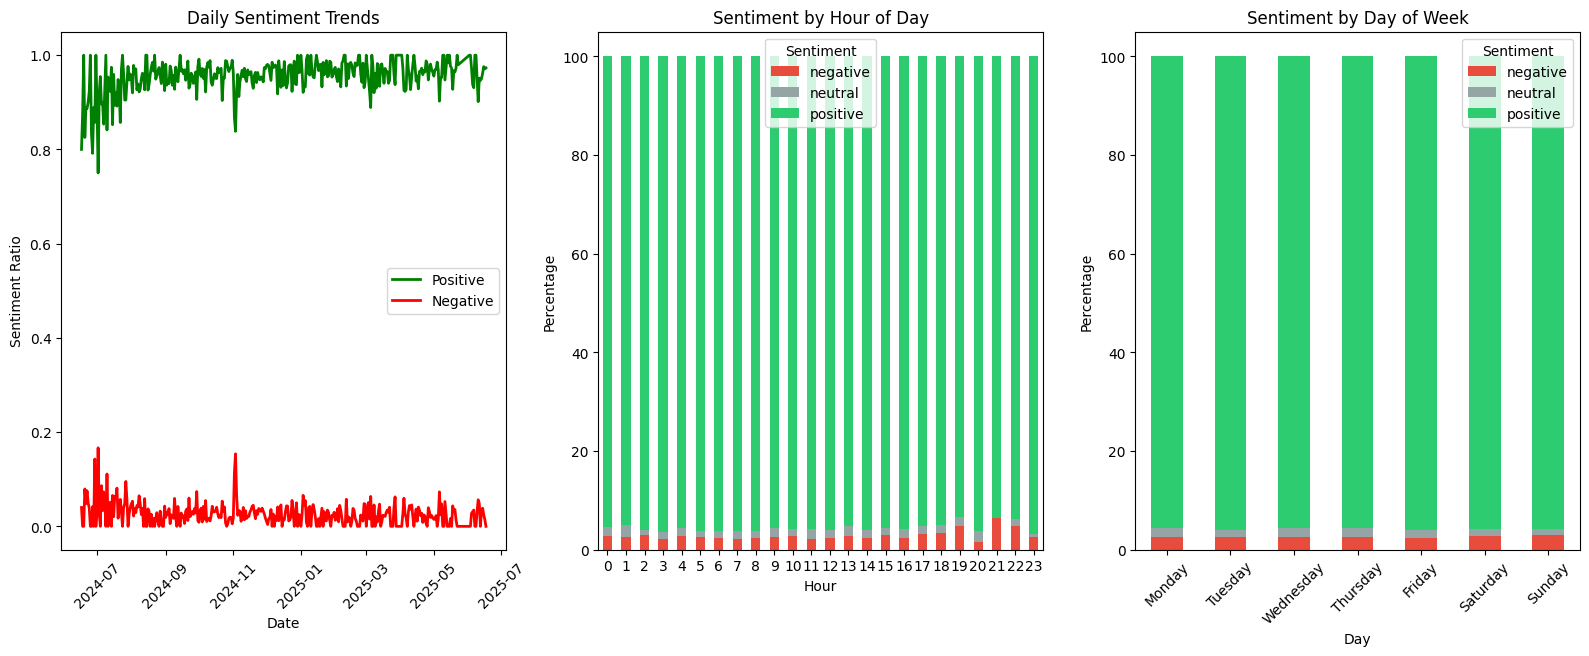

📊 Temporal insights:
  • Most active hour: 14:00
  • Most active day: Tuesday
  • Most positive hour: 14:00
  • Most negative hour: 15:00


In [10]:
# =============================================================================
# BLOCK 8: TEMPORAL SENTIMENT ANALYSIS (if timestamps available)
# =============================================================================

if timestamp_col and df_clean['parsed_datetime'].notna().sum() > 0:
    print(f"\n📅 PHASE 7: TEMPORAL SENTIMENT ANALYSIS")
    print("-"*50)
    
    # Daily sentiment trends
    daily_sentiment = df_clean.groupby([df_clean['parsed_datetime'].dt.date, 'sentiment_label']).size().unstack(fill_value=0)
    
    # Calculate sentiment ratios
    if not daily_sentiment.empty:
        daily_sentiment['total'] = daily_sentiment.sum(axis=1)
        for sentiment in ['positive', 'negative', 'neutral']:
            if sentiment in daily_sentiment.columns:
                daily_sentiment[f'{sentiment}_ratio'] = daily_sentiment[sentiment] / daily_sentiment['total']
    
    # Hourly patterns
    hourly_sentiment = df_clean.groupby(['hour', 'sentiment_label']).size().unstack(fill_value=0)
    
    # Day of week patterns
    dow_sentiment = df_clean.groupby(['day_of_week', 'sentiment_label']).size().unstack(fill_value=0)
    
    # Create temporal visualizations
    plt.figure(figsize=(16, 12))
    
    # Daily sentiment trends
    if len(daily_sentiment) > 1:
        plt.subplot(2, 3, 1)
        for sentiment in ['positive', 'negative']:
            ratio_col = f'{sentiment}_ratio'
            if ratio_col in daily_sentiment.columns:
                plt.plot(daily_sentiment.index, daily_sentiment[ratio_col], 
                        label=sentiment.capitalize(), linewidth=2,
                        color='green' if sentiment == 'positive' else 'red')
        plt.title('Daily Sentiment Trends')
        plt.xlabel('Date')
        plt.ylabel('Sentiment Ratio')
        plt.legend()
        plt.xticks(rotation=45)
    
    # Hourly sentiment patterns
    if not hourly_sentiment.empty:
        plt.subplot(2, 3, 2)
        hourly_sentiment_pct = hourly_sentiment.div(hourly_sentiment.sum(axis=1), axis=0) * 100
        hourly_sentiment_pct.plot(kind='bar', stacked=True, ax=plt.gca(),
                                 color=['#e74c3c', '#95a5a6', '#2ecc71'])
        plt.title('Sentiment by Hour of Day')
        plt.xlabel('Hour')
        plt.ylabel('Percentage')
        plt.legend(title='Sentiment')
        plt.xticks(rotation=0)
    
    # Day of week sentiment patterns
    if not dow_sentiment.empty:
        plt.subplot(2, 3, 3)
        dow_sentiment_pct = dow_sentiment.div(dow_sentiment.sum(axis=1), axis=0) * 100
        dow_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
        dow_sentiment_pct = dow_sentiment_pct.reindex(dow_order, fill_value=0)
        dow_sentiment_pct.plot(kind='bar', stacked=True, ax=plt.gca(),
                              color=['#e74c3c', '#95a5a6', '#2ecc71'])
        plt.title('Sentiment by Day of Week')
        plt.xlabel('Day')
        plt.ylabel('Percentage')
        plt.legend(title='Sentiment')
        plt.xticks(rotation=45)
    
    plt.tight_layout()
    plt.show()
    
    print("📊 Temporal insights:")
    print(f"  • Most active hour: {df_clean['hour'].mode().iloc[0]}:00")
    print(f"  • Most active day: {df_clean['day_of_week'].mode().iloc[0]}")
    
    # Calculate peak sentiment times
    if not hourly_sentiment.empty and 'positive' in hourly_sentiment.columns:
        positive_peak_hour = hourly_sentiment['positive'].idxmax()
        negative_peak_hour = hourly_sentiment['negative'].idxmax() if 'negative' in hourly_sentiment.columns else None
        print(f"  • Most positive hour: {positive_peak_hour}:00")
        if negative_peak_hour is not None:
            print(f"  • Most negative hour: {negative_peak_hour}:00")


📈 PHASE 8: ADVANCED ANALYTICS
--------------------------------------------------
🔗 Correlation analysis...


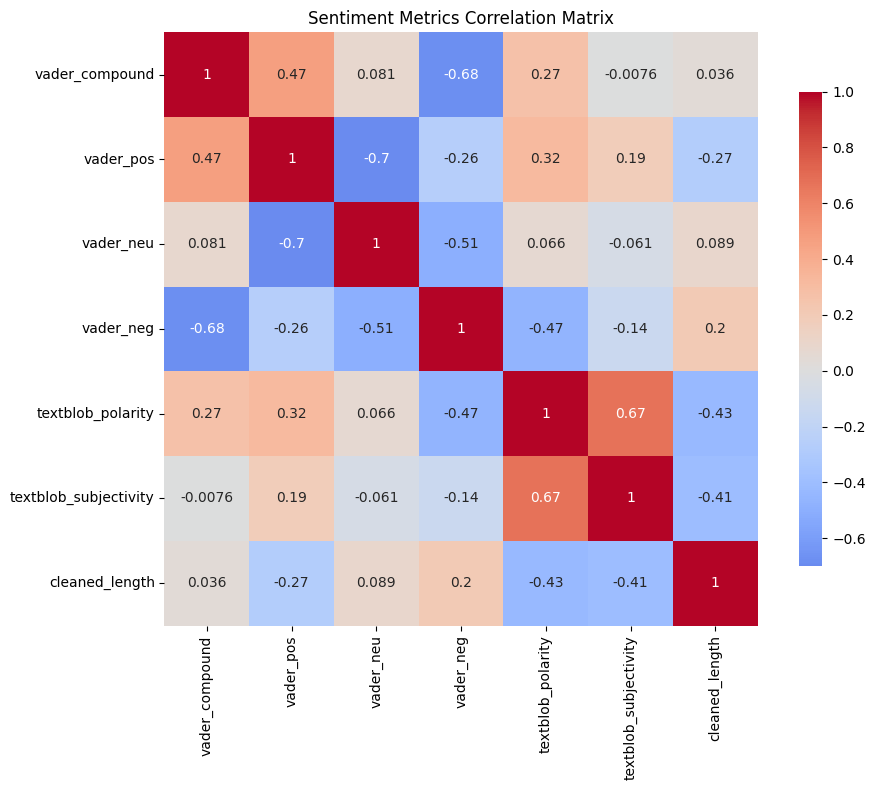


🔍 Strongest correlations:
  • vader_pos ↔ vader_neu: -0.700
  • vader_compound ↔ vader_neg: -0.679
  • textblob_polarity ↔ textblob_subjectivity: 0.673
  • vader_neu ↔ vader_neg: -0.506
  • vader_neg ↔ textblob_polarity: -0.472

📊 Statistical insights:
  • Average sentiment score: 0.722
  • Sentiment standard deviation: 0.272
  • Most polarized posts: 32,804 (90.4%)

🏆 Extreme sentiment examples:

Most Positive Post (Score: 0.999):
'love❤️ OP of both L05220045 and L05230017 This advice probably applies to everyone, regardless if you graduated or not, but the first step to meeting new friends first starts with being a good friend....'

Most Negative Post (Score: -1.000):
'studies✍🏼 stress stress stress stress stress stress stress stress stress stress stress stress stress stress stress stress stress stress stress stress stress stress stress stress stress stress stress s...'


In [11]:
# =============================================================================
# BLOCK 9: ADVANCED ANALYTICS AND CORRELATIONS
# =============================================================================

print(f"\n📈 PHASE 8: ADVANCED ANALYTICS")
print("-"*50)

# Correlation analysis
print("🔗 Correlation analysis...")
sentiment_cols = ['vader_compound', 'vader_pos', 'vader_neu', 'vader_neg', 
                  'textblob_polarity', 'textblob_subjectivity', 'cleaned_length']
existing_cols = [col for col in sentiment_cols if col in df_clean.columns]

if len(existing_cols) > 1:
    corr_matrix = df_clean[existing_cols].corr()
    
    plt.figure(figsize=(10, 8))
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0, 
                square=True, cbar_kws={'shrink': 0.8})
    plt.title('Sentiment Metrics Correlation Matrix')
    plt.tight_layout()
    plt.show()
    
    # Print strongest correlations
    print("\n🔍 Strongest correlations:")
    mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
    corr_matrix_masked = corr_matrix.mask(mask)
    
    # Get correlation pairs
    corr_pairs = []
    for i in range(len(corr_matrix.columns)):
        for j in range(i+1, len(corr_matrix.columns)):
            corr_val = corr_matrix.iloc[i, j]
            corr_pairs.append((corr_matrix.columns[i], corr_matrix.columns[j], corr_val))
    
    # Sort by absolute correlation
    corr_pairs.sort(key=lambda x: abs(x[2]), reverse=True)
    
    for col1, col2, corr_val in corr_pairs[:5]:
        print(f"  • {col1} ↔ {col2}: {corr_val:.3f}")

# Statistical insights
print(f"\n📊 Statistical insights:")
print(f"  • Average sentiment score: {df_clean['vader_compound'].mean():.3f}")
print(f"  • Sentiment standard deviation: {df_clean['vader_compound'].std():.3f}")
print(f"  • Most polarized posts: {((df_clean['vader_compound'].abs() > 0.5).sum()):,} ({((df_clean['vader_compound'].abs() > 0.5).mean()*100):.1f}%)")

# Identify most positive and negative posts
print(f"\n🏆 Extreme sentiment examples:")
most_positive = df_clean.loc[df_clean['vader_compound'].idxmax()]
most_negative = df_clean.loc[df_clean['vader_compound'].idxmin()]

print(f"\nMost Positive Post (Score: {most_positive['vader_compound']:.3f}):")
print(f"'{str(most_positive['cleaned_text'])[:200]}...'")

print(f"\nMost Negative Post (Score: {most_negative['vader_compound']:.3f}):")
print(f"'{str(most_negative['cleaned_text'])[:200]}...'")


In [12]:
 #=============================================================================
# BLOCK 10: COMPREHENSIVE SUMMARY REPORT
# =============================================================================

print(f"\n📋 PHASE 9: COMPREHENSIVE SUMMARY REPORT")
print("="*70)

# Dataset summary
print(f"\n📊 DATASET SUMMARY")
print(f"  • Total posts analyzed: {len(df_clean):,}")
print(f"  • Average post length: {df_clean['cleaned_length'].mean():.1f} characters")
print(f"  • Date range: {df_clean['parsed_datetime'].min().strftime('%Y-%m-%d') if timestamp_col else 'N/A'} to {df_clean['parsed_datetime'].max().strftime('%Y-%m-%d') if timestamp_col else 'N/A'}")
print(f"  • Unique words identified: {len(word_freq):,}")

# Sentiment summary
print(f"\n😊 SENTIMENT ANALYSIS SUMMARY")
sentiment_summary = df_clean['sentiment_label'].value_counts()
for sentiment, count in sentiment_summary.items():
    percentage = count / len(df_clean) * 100
    print(f"  • {sentiment.capitalize()}: {count:,} posts ({percentage:.1f}%)")

print(f"  • Average sentiment score: {df_clean['vader_compound'].mean():.3f} (scale: -1 to +1)")
print(f"  • Sentiment volatility (std dev): {df_clean['vader_compound'].std():.3f}")

# Content insights
print(f"\n📝 CONTENT INSIGHTS")
print(f"  • Most common word: '{top_words[0][0]}' ({top_words[0][1]:,} occurrences)")
print(f"  • Average subjectivity: {df_clean['textblob_subjectivity'].mean():.3f} (0=objective, 1=subjective)")

if timestamp_col:
    print(f"\n⏰ TEMPORAL PATTERNS")
    print(f"  • Most active hour: {df_clean['hour'].mode().iloc[0]}:00")
    print(f"  • Most active day: {df_clean['day_of_week'].mode().iloc[0]}")
    print(f"  • Posts per day (average): {len(df_clean) / (df_clean['parsed_datetime'].max() - df_clean['parsed_datetime'].min()).days:.1f}")

# Quality indicators
print(f"\n✅ DATA QUALITY INDICATORS")
print(f"  • Text cleaning retention rate: {len(df_clean)/len(df)*100:.1f}%")
print(f"  • Posts with valid timestamps: {df_clean['parsed_datetime'].notna().sum() if timestamp_col else 0:,}")
print(f"  • Average words per post: {sum(len(str(text).split()) for text in df_clean['cleaned_text']) / len(df_clean):.1f}")

print(f"\n🎯 KEY RECOMMENDATIONS")
print(f"  • Monitor posts during peak hours ({df_clean['hour'].mode().iloc[0]}:00) for maximum engagement" if timestamp_col else "  • Consider adding timestamp data for temporal analysis")
print(f"  • Focus on {'positive' if sentiment_summary.iloc[0] == sentiment_summary['positive'] else 'balanced'} content strategy")
print(f"  • Optimal post length appears to be around {df_clean.groupby('sentiment_label')['cleaned_length'].mean().max():.0f} characters for positive sentiment")

print(f"\n" + "="*70)
print(f"ANALYSIS COMPLETE! 🎉")
print(f"="*70)


📋 PHASE 9: COMPREHENSIVE SUMMARY REPORT

📊 DATASET SUMMARY
  • Total posts analyzed: 36,275
  • Average post length: 260.6 characters
  • Date range: 2024-06-17 to 2025-06-17
  • Unique words identified: 29,604

😊 SENTIMENT ANALYSIS SUMMARY
  • Positive: 34,738 posts (95.8%)
  • Negative: 958 posts (2.6%)
  • Neutral: 579 posts (1.6%)
  • Average sentiment score: 0.722 (scale: -1 to +1)
  • Sentiment volatility (std dev): 0.272

📝 CONTENT INSIGHTS
  • Most common word: 'class' (1,587 occurrences)
  • Average subjectivity: 0.782 (0=objective, 1=subjective)

⏰ TEMPORAL PATTERNS
  • Most active hour: 14:00
  • Most active day: Tuesday
  • Posts per day (average): 99.4

✅ DATA QUALITY INDICATORS
  • Text cleaning retention rate: 100.0%
  • Posts with valid timestamps: 36,275
  • Average words per post: 49.9

🎯 KEY RECOMMENDATIONS
  • Monitor posts during peak hours (14:00) for maximum engagement
  • Focus on positive content strategy
  • Optimal post length appears to be around 432 charac